In [1]:
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]

First we import eBird and hydrometric data that we've previously extracted.

In [3]:
ebirds = pd.read_csv('ebird.csv')
depths = pd.read_csv('depths.csv')

Next, we round the depths to centimeters. This will allow us to group observations made at similar water depths together which reduces the noisiness of the results.

In [4]:
depths.depth = depths.depth.apply(lambda x: round(x, 2))

Next we have a look at some basic summary statistics about the depth:

In [5]:
min(depths['depth']), depths['depth'].mean(), depths['depth'].median(), max(depths['depth'])

(57.55, 58.384412225705326, 58.37, 60.44)

Next, we plot the depths:

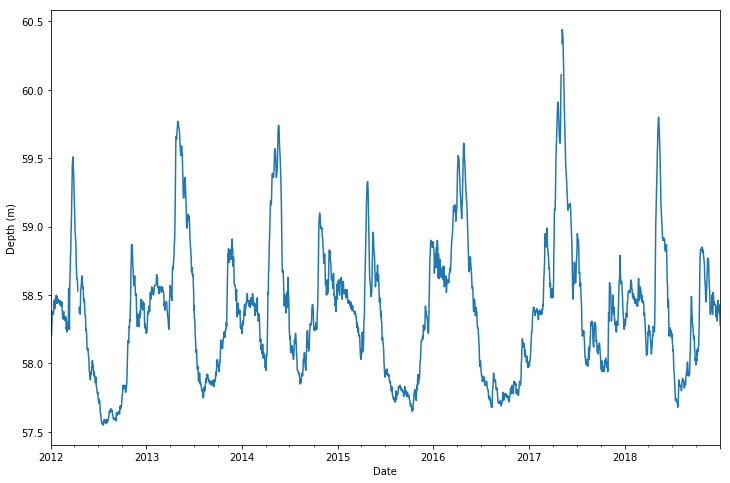

In [6]:
d = pd.DataFrame(depths['depth'].values, index=pd.to_datetime(depths['date']))
ax = d.plot.line()
ax.set_xlabel('Date')
ax.set_ylabel('Depth (m)')
ax.get_legend().remove()
None

We drop any observations where an accurate count of the birds was not made. This affects 3295 of the 48385 observations.

In [7]:
len(ebirds[ebirds['count'] == 'X']), len(ebirds)

(109553, 1873995)

In [8]:
ebirds[ebirds['count'] == 'X'] = 1

In [9]:
ebirds['count'] = ebirds['count'].map(int)

We convert the dates to datetime objects, remove the times from the eBird data as the depth data is only given for each day. This allows us to combine the eBird observations with the water depth on that particular date.

In [10]:
ebirds.date = pd.to_datetime(pd.to_datetime(ebirds.date).dt.date)
depths.date = pd.to_datetime(depths.date)
birds = pd.merge(ebirds, depths, on='date')

Now we define a function to determine whether or not a given species is considered a shorebird. For this, we use the Ontario Field Ornithologist's [Checklist of the Birds of Ontario](http://www.ofo.ca/site/page/view/checklist.checklist). We consider any species listed under *Stilts and Avocets*, *Oystercatchers*, *Plovers and Lapwings* and *Sandpipers and Allies* a shorebird.

In [11]:
def is_shorebird(name):
    return name in ['Black-necked Stilt',
                    'American Avocet',
                    'American Oystercatcher',
                    'Black-bellied Plover',
                    'American Golden-Plover',
                    'Lesser Sand-Plover',
                    'Snowy Plover',
                    'Wilson\'s Plover',
                    'Common Ringed Plover',
                    'Semipalmated Plover',
                    'Piping Plover',
                    'Killdeer',
                    'Eurasian Dotterel',
                    'Upland Sandpiper',
                    'Whimbrel',
                    'Eskimo Curlew',
                    'Long-billed Curlew',
                    'Slender-billed Curlew',
                    'Black-tailed Godwit',
                    'Hudsonian Godwit',
                    'Marbled Godwit',
                    'Ruddy Turnstone',
                    'Red Knot',
                    'Ruff',
                    'Sharp-tailed Sandpiper',
                    'Stilt Sandpiper',
                    'Curlew Sandpiper',
                    'Sanderling',
                    'Dunlin',
                    'Purple Sandpiper',
                    'Baird\'s Sandpiper',
                    'Little Stint',
                    'Least Sandpiper',
                    'White-rumped Sandpiper',
                    'Buff-breasted Sandpiper',
                    'Pectoral Sandpiper',
                    'Semipalmated Sandpiper',
                    'Western Sandpiper',
                    'Short-billed Dowitcher',
                    'Long-billed Dowitcher',
                    'American Woodcock',
                    'Wilson\'s Snipe',
                    'Spotted Sandpiper',
                    'Solitary Sandpiper',
                    'Wandering Tattler',
                    'Lesser Yellowlegs',
                    'Willet',
                    'Spotted Redshank',
                    'Greater Yellowlegs',
                    'Wilson\'s Phalarope',
                    'Red-necked Phalarope',
                    'Red Phalarope'
                   ]

With this function defined we can then add a column indicating whether or not a particular bird is considered a shorebird.

In [12]:
birds['is_shorebird'] = birds['name'].map(is_shorebird)

How many shorebird observations are for a location of interest?

In [13]:
shorebirds = birds[birds['is_shorebird'] == True]
ofnc_shorebirds = shorebirds[shorebirds['location'] == 'OFNC Study Area']
shorebirds = shorebirds[shorebirds['location'] != 'OFNC Study Area']
shorebirds.count()['count'], ofnc_shorebirds.count()['count'], shorebirds.count()['count'] / ofnc_shorebirds.count()['count']

(11645, 35831, 0.32499790684044544)

From here on, we only care about observations at one of our locations of interest.

In [14]:
birds = birds[birds['location'] != 'OFNC Study Area']

In [15]:
by_depth = birds.groupby(['depth', 'is_shorebird']).count().unstack('is_shorebird')

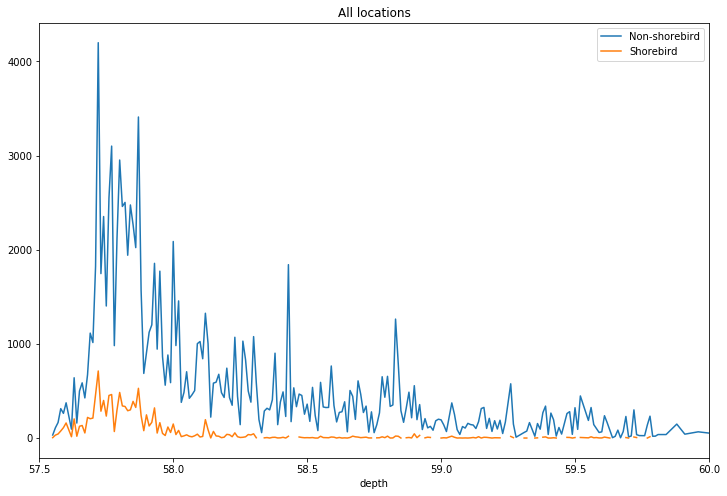

In [16]:
ax = by_depth['count'].plot.line(xlim=[57.5, 60.0])
ax.legend(['Non-shorebird', 'Shorebird'])
ax.set_title('All locations')
None

In [17]:
shorebirds = birds[birds['is_shorebird'] == True].groupby('name')
shorebirds = shorebirds.agg({'count': 'sum'})
shorebirds['percentage'] = round(100.0*shorebirds['count']/sum(shorebirds['count']), 1)
shorebirds.sort_values('count', ascending=False)

,count,percentage
name,,
Semipalmated Sandpiper,13744,19.8
Least Sandpiper,12394,17.8
Killdeer,11864,17.1
Lesser Yellowlegs,11305,16.3
Spotted Sandpiper,4568,6.6
Semipalmated Plover,3827,5.5
Greater Yellowlegs,1869,2.7
Wilson's Snipe,1811,2.6
Pectoral Sandpiper,1608,2.3


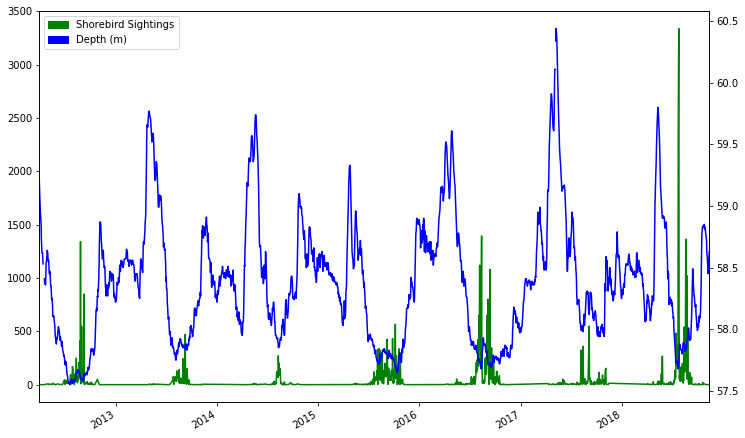

In [23]:
shorebirds = birds[birds['is_shorebird'] == True].groupby('date')
shorebirds = shorebirds.agg({'count': 'sum'})
ax = shorebirds.plot.line(color='green')
ax.set_xlabel('')
#ax.set_ylabel('Shorebird Observations')
ax2 = ax.twinx()
d = pd.DataFrame(depths['depth'].values, index=pd.to_datetime(depths['date']))
ax2.plot(d.index, d[0], color='blue')
ax2.set_ylabel('')

p = mpatches.Patch(color='green', label='Shorebird Sightings')
p2 = mpatches.Patch(color='blue', label='Depth (m)')
ax.legend(handles=[p, p2])
None

This shows a strong correllation between Ottawa River water depth and shorebird observations. Most shorebirds are seen in the late summer and early fall when the river water levels are at their lowest. The Carp River Reclamation Area is not on the river and is a suggested location to look for shorebirds when conditions on the Ottawa River are not favourable. Do we see more observations at a higher depth at this site?

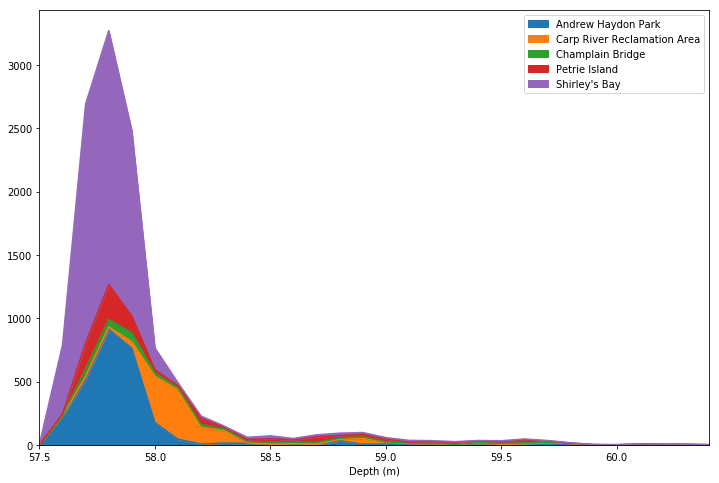

In [27]:
shorebirds = birds[birds['is_shorebird'] == True].copy()
shorebirds['rounded_depth'] = shorebirds.depth.apply(lambda x: round(x, 1))
ax = shorebirds.groupby(['rounded_depth', 'location']).count().unstack('location')['count'].plot.area()
ax.set_xlabel('Depth (m)')
ax.legend_.set_title('')
None

We are interested in five locations for Shorebirds in Ottawa.

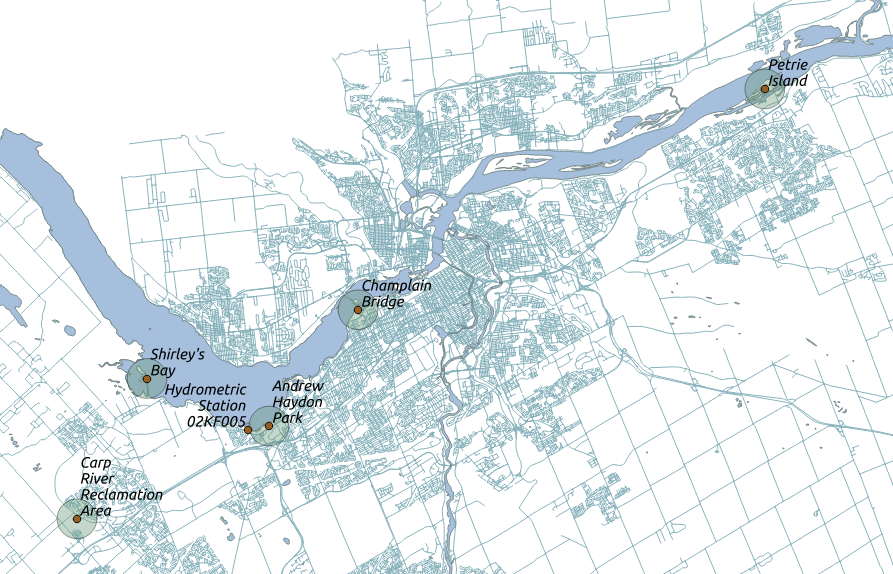

In [20]:
andrew_haydon = birds[birds['location'] == 'Andrew Haydon Park']
carp_river = birds[birds['location'] == 'Carp River Reclamation Area']
champlain_bridge = birds[birds['location'] == 'Champlain Bridge']
petrie_island = birds[birds['location'] == 'Petrie Island']
shirleys_bay = birds[birds['location'] == 'Shirley\'s Bay']

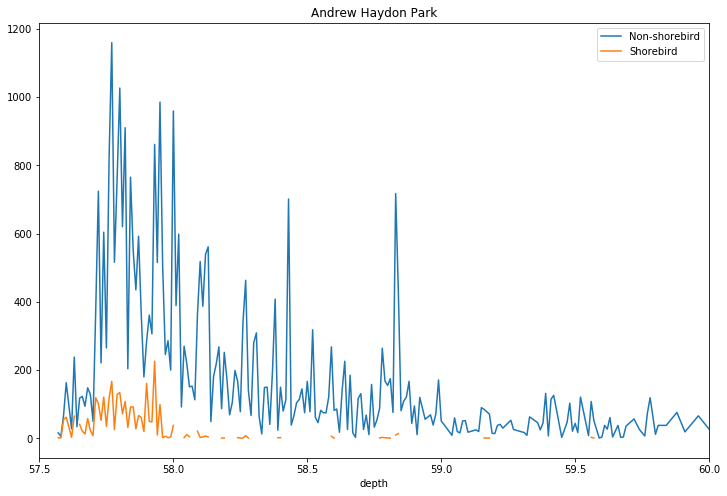

In [21]:
by_depth = andrew_haydon.groupby(['depth', 'is_shorebird']).count().unstack('is_shorebird')
ax = by_depth['count'].plot.line(xlim=[57.5, 60.0])
ax.legend(['Non-shorebird', 'Shorebird'])
ax.set_title('Andrew Haydon Park')
None

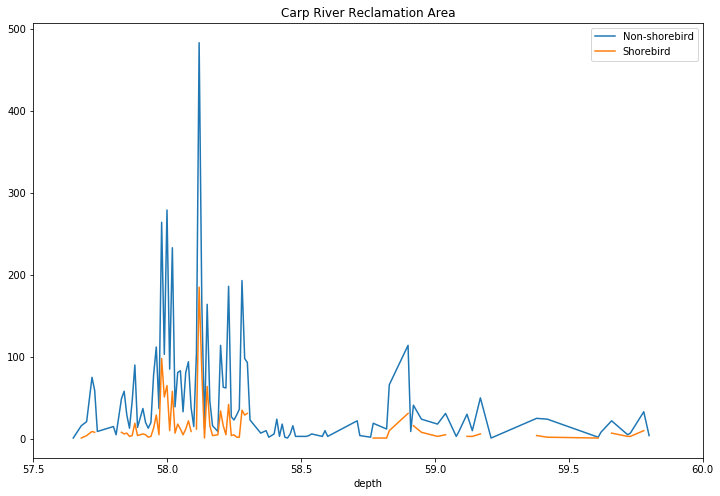

In [22]:
by_depth = carp_river.groupby(['depth', 'is_shorebird']).count().unstack('is_shorebird')
ax = by_depth['count'].plot.line(xlim=[57.5, 60.0])
ax.legend(['Non-shorebird', 'Shorebird'])
ax.set_title('Carp River Reclamation Area')
None

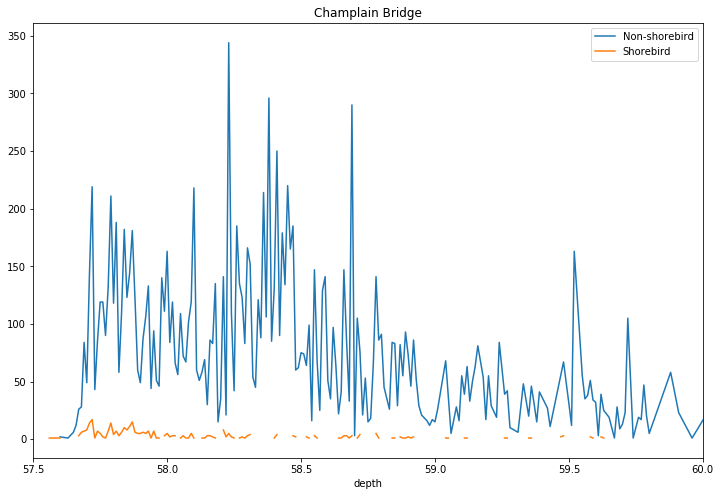

In [23]:
by_depth = champlain_bridge.groupby(['depth', 'is_shorebird']).count().unstack('is_shorebird')
ax = by_depth['count'].plot.line(xlim=[57.5, 60.0])
ax.legend(['Non-shorebird', 'Shorebird'])
ax.set_title('Champlain Bridge')
None

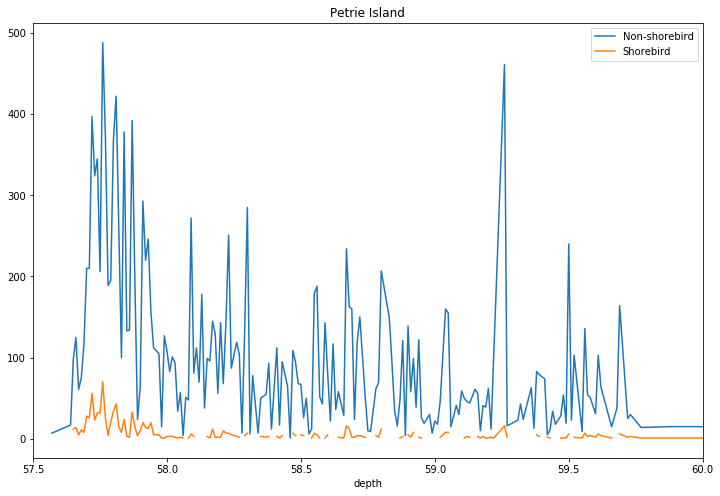

In [24]:
by_depth = petrie_island.groupby(['depth', 'is_shorebird']).count().unstack('is_shorebird')
ax = by_depth['count'].plot.line(xlim=[57.5, 60.0])
ax.legend(['Non-shorebird', 'Shorebird'])
ax.set_title('Petrie Island')
None

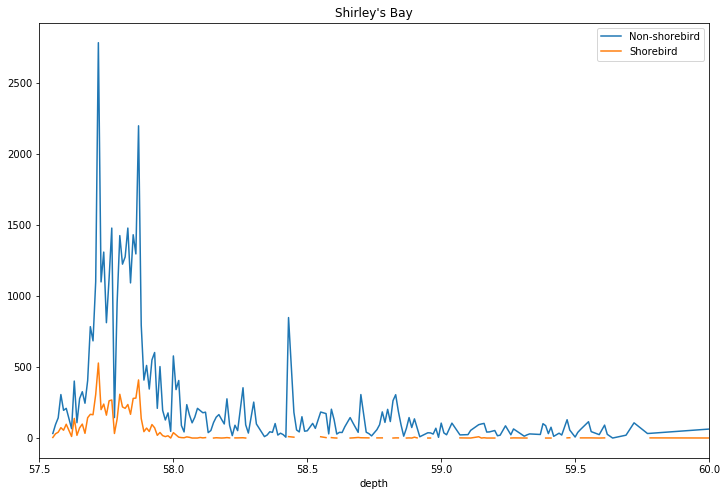

In [25]:
by_depth = shirleys_bay.groupby(['depth', 'is_shorebird']).count().unstack('is_shorebird')
ax = by_depth['count'].plot.line(xlim=[57.5, 60.0])
ax.legend(['Non-shorebird', 'Shorebird'])
ax.set_title('Shirley\'s Bay')
None

In [26]:
def depth_observation_percentile(df, percentage):
    """ Return the depth at which percentage observations have been made"""
    cs = df.loc[df['is_shorebird'] == True].groupby('depth').agg({'count': 'sum'})
    total = sum(cs['count'])
    cs['percentage'] = 100.0*(cs.cumsum() / total)

    for i, x in enumerate(cs['percentage']):
        if x >= percentage:
            return(cs.index[i], x)

In [47]:
for site in [shirleys_bay, carp_river, andrew_haydon, champlain_bridge, petrie_island]:
    print(site['location'].head(1).values[0])
    for percentile in [50, 75, 95]:
        print(depth_observation_percentile(site, percentile))

Shirley's Bay
(57.73, 50.20096463022507)
(57.83, 77.04983922829582)
(57.9, 95.22550346928415)
Carp River Reclamation Area
(58.12, 53.350165080598174)
(58.23, 76.13128762866576)
(58.95, 95.33890075742862)
Andrew Haydon Park
(57.77, 51.93521594684385)
(57.85, 75.7641196013289)
(58.09, 95.28239202657808)
Champlain Bridge
(57.87, 52.452202826267666)
(58.31, 75.31172069825436)
(59.48, 95.51122194513717)
Petrie Island
(57.77, 51.809124278972206)
(57.88, 75.51127425275301)
(59.04, 95.4116413214473)


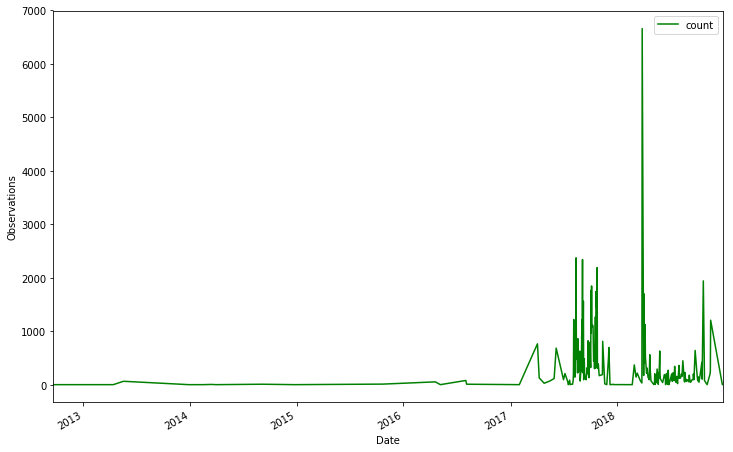

In [32]:
df = carp_river.groupby('date')
df = df.agg({'count': 'sum'})
ax = df.plot.line(color='green')
ax.set_xlabel('Date')
ax.set_ylabel('Observations')
None

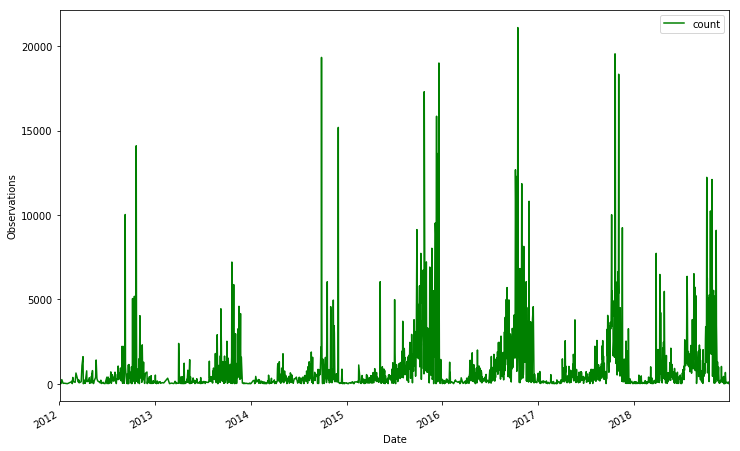

In [33]:
df = birds.groupby('date')
df = df.agg({'count': 'sum'})
ax = df.plot.line(color='green')
ax.set_xlabel('Date')
ax.set_ylabel('Observations')
None

In [34]:
shorebirds = birds[birds['is_shorebird'] == True]
shorebirds = shorebirds[shorebirds['location'] == 'Petrie Island'].groupby('name')
shorebirds = shorebirds.agg({'count': 'sum'})
shorebirds['percentage'] = round(100.0*shorebirds['count']/sum(shorebirds['count']), 1)
shorebirds.sort_values('count', ascending=False)

,count,percentage
name,,
Killdeer,1645,43.1
Wilson's Snipe,1014,26.6
Spotted Sandpiper,346,9.1
Solitary Sandpiper,242,6.3
Least Sandpiper,231,6.1
Lesser Yellowlegs,177,4.6
Semipalmated Plover,41,1.1
Greater Yellowlegs,29,0.8
Semipalmated Sandpiper,24,0.6


In [35]:
shorebirds = birds[birds['is_shorebird'] == True]
shorebirds = shorebirds[shorebirds['location'] == 'Shirley\'s Bay'].groupby('name')
shorebirds = shorebirds.agg({'count': 'sum'})
shorebirds['percentage'] = round(100.0*shorebirds['count']/sum(shorebirds['count']), 1)
shorebirds.sort_values('count', ascending=False)

,count,percentage
name,,
Lesser Yellowlegs,9918,21.0
Semipalmated Sandpiper,9812,20.8
Least Sandpiper,9721,20.6
Killdeer,6070,12.8
Semipalmated Plover,2504,5.3
Spotted Sandpiper,2378,5.0
Pectoral Sandpiper,1327,2.8
Greater Yellowlegs,1276,2.7
White-rumped Sandpiper,1178,2.5


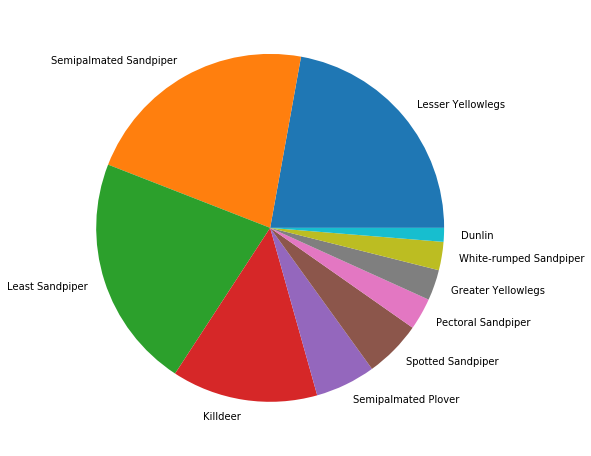

In [64]:
shorebirds = birds[birds['is_shorebird'] == True]
shorebirds = shorebirds[shorebirds['location'] == 'Shirley\'s Bay'].groupby('name')
shorebirds = shorebirds.agg({'count': 'sum'})
ax = pd.DataFrame(shorebirds.sort_values("count", ascending=False))["count"].head(10).plot.pie()
ax.set_ylabel("")
None

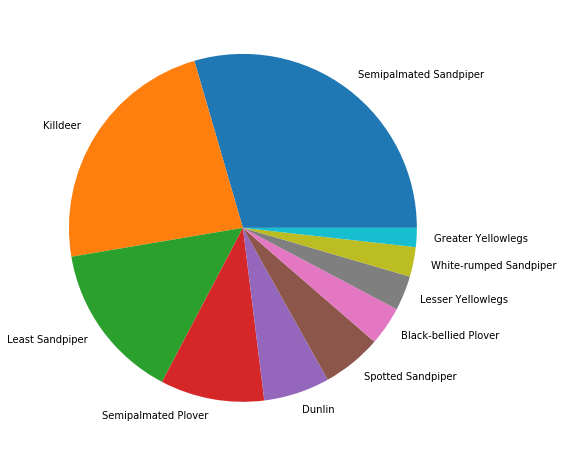

In [65]:
shorebirds = birds[birds['is_shorebird'] == True]
shorebirds = shorebirds[shorebirds['location'] == 'Andrew Haydon Park'].groupby('name')
shorebirds = shorebirds.agg({'count': 'sum'})
ax = pd.DataFrame(shorebirds.sort_values("count", ascending=False))["count"].head(10).plot.pie()
ax.set_ylabel("")
None

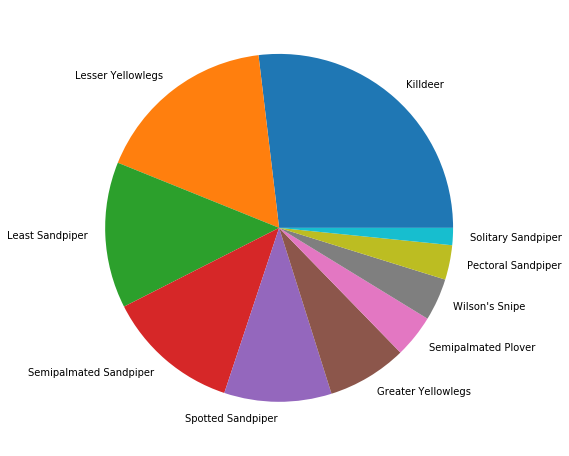

In [67]:
shorebirds = birds[birds['is_shorebird'] == True]
shorebirds = shorebirds[shorebirds['location'] == 'Carp River Reclamation Area'].groupby('name')
shorebirds = shorebirds.agg({'count': 'sum'})
ax = pd.DataFrame(shorebirds.sort_values("count", ascending=False))["count"].head(10).plot.pie()
ax.set_ylabel("")
None

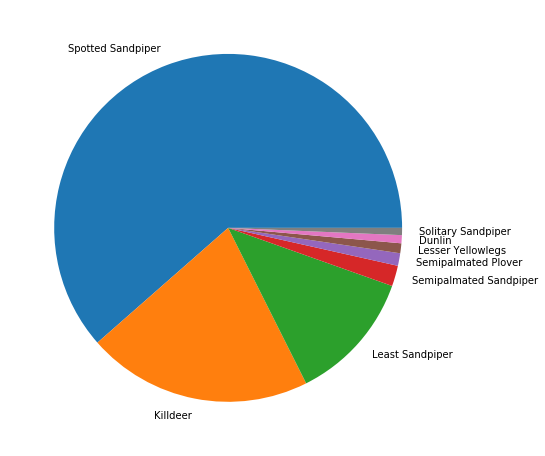

In [69]:
shorebirds = birds[birds['is_shorebird'] == True]
shorebirds = shorebirds[shorebirds['location'] == 'Champlain Bridge'].groupby('name')
shorebirds = shorebirds.agg({'count': 'sum'})
ax = pd.DataFrame(shorebirds.sort_values("count", ascending=False))["count"].head(8).plot.pie()
ax.set_ylabel("")
None

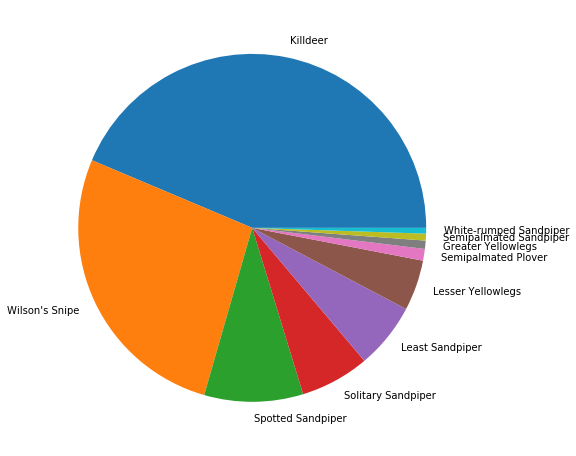

In [41]:
shorebirds = birds[birds['is_shorebird'] == True]
shorebirds = shorebirds[shorebirds['location'] == 'Petrie Island'].groupby('name')
shorebirds = shorebirds.agg({'count': 'sum'})
ax = pd.DataFrame(shorebirds.sort_values("count", ascending=False))["count"].head(10).plot.pie()
ax.set_ylabel("")
None